In [1]:
import torch
from glob import glob
from ast import literal_eval

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from IPython.core.display import display, HTML
from sklearn.manifold import TSNE
from tqdm.notebook import tqdm
import networkx as nx

In [2]:
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

plt.style.use('dark_background')

display(HTML("<style>"
    + "#notebook { padding-top:0px; } " ""
    + ".container { width:100%; } "
    + ".end_space { min-height:0px; } "
    + "</style>"))

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

device: cuda


In [3]:
def print_exp_info(exp: dict):
    print(f'model: {exp["model"]} {exp["approach"]}')
    print({k: exp[k] for k in exp if k not in ['logs', 'results', 'knowledge']})

# usage example:  show_exp_images(experiments[0], True)
def show_exp_images(exp: dict, show_origins=False):
    for task in exp['results']:
        cur_images = exp['results'][task]['images']
        fig, axs = plt.subplots(2, 5, figsize=(15, 8))
        fig.suptitle(f'TASK {task} {exp["knowledge"][task]}', fontsize=30)
        for r, row in enumerate(axs):
            for c, cell in enumerate(row):
                idx = r*5 + c
                image = np.zeros((28, 28, 3), dtype=float)
                cell.set_title(cur_images[idx]['label'])
                orig = np.array(cur_images[idx]['original'][0])
                recon = np.array(cur_images[idx]['reconstruction'][0]).clip(0, 1)
                if show_origins:
                    image[:,:,1] = orig
                image[:,:,0] = recon
                image[:,:,2] = recon
                cell.imshow(image)
        plt.show()

In [4]:
def calc_ADL_from_dist(dist_matrix: torch.Tensor, sigma=1.):
    # compute affinity matrix, heat_kernel
    A = torch.exp(-dist_matrix / (sigma ** 2))
    # compute degree matrix
    D = torch.diag(A.sum(1))
    # compute laplacian
    L = D - A
    return A, D, L

def calc_euclid_dist(data: torch.Tensor):
    return ((data.unsqueeze(0) - data.unsqueeze(1)) ** 2).sum(-1)

def calc_dist_weiss(nu: torch.Tensor, logvar: torch.Tensor):
    var = logvar.exp()
    edist = calc_euclid_dist(nu)
    wdiff = (var.unsqueeze(0) + var.unsqueeze(1) -2*(torch.sqrt(var.unsqueeze(0)*var.unsqueeze(1)))).sum(-1)
    return edist + wdiff

def calc_ADL_knn(distances: torch.Tensor, k: int, symmetric: bool = True):
    new_A = torch.clone(distances)
    mask = torch.eye(new_A.shape[0])
    new_A[mask==1] = +torch.inf

    final_A = torch.zeros_like(new_A)
    idxes = new_A.topk(k, largest=False)[1]
    final_A[torch.arange(len(idxes)).unsqueeze(1), idxes] = 1

    if symmetric:
        final_A = ((final_A + final_A.T) > 0).float()
        # final_A = 0.5*(final_A + final_A.T)

    # compute degree matrix
    D = torch.diag(final_A.sum(1))
    # compute laplacian
    L = D - final_A
    return final_A, D, L

def calc_ADL(data: torch.Tensor, sigma=1.):
    return calc_ADL_from_dist(calc_euclid_dist(data), sigma)

def find_eigs(laplacian: torch.Tensor):
    eigenvalues, eigenvectors = torch.linalg.eig(laplacian)
    eigenvalues = eigenvalues.to(float)
    eigenvectors = eigenvectors.to(float)
    sorted_indices = torch.argsort(eigenvalues)
    eigenvalues, eigenvectors = eigenvalues[sorted_indices], eigenvectors[:,sorted_indices]
    return eigenvalues, eigenvectors

def calc_energy_from_values(values: torch.Tensor, norm=False):
    nsamples = len(values)
    max_value = nsamples - 1 if norm else nsamples * (nsamples - 1)
    dir_energy = values.sum()
    energy_p = dir_energy / max_value
    return energy_p.cpu().item()

def normalize_A(A, D):
    return torch.sqrt(torch.linalg.inv(D)) @ A @ torch.sqrt(torch.linalg.inv(D))

def dir_energy_normal(data: torch.Tensor, sigma=1.):
    A, D, L = calc_ADL(data, sigma)
    L_norm = torch.eye(A.shape[0]).to(device) - normalize_A(A, D)
    eigenvalues, eigenvectors = find_eigs(L_norm)
    energy = calc_energy_from_values(eigenvalues, norm=True)
    return energy, eigenvalues, eigenvectors

def dir_energy(data: torch.Tensor, sigma=1):
    A, D, L = calc_ADL(data, sigma=sigma)
    eigenvalues, eigenvectors = find_eigs(L)
    energy = calc_energy_from_values(eigenvalues)
    return energy

def laplacian_analysis(data: torch.Tensor, sigma=1., knn=0, logvars: torch.Tensor=None,
                       norm_lap=False, norm_eigs=False):
    if logvars is None:
        distances = calc_euclid_dist(data)
    else:
        distances = calc_dist_weiss(data, logvars)
    if knn > 0:
        A, D, L = calc_ADL_knn(distances, knn, symmetric=True)
    else:
        A, D, L = calc_ADL_from_dist(distances, sigma)
    if norm_lap:
        L = torch.eye(A.shape[0]).to(device) - normalize_A(A, D)
    eigenvalues, eigenvectors = find_eigs(L)
    energy = calc_energy_from_values(eigenvalues, norm=norm_lap)
    if norm_eigs and not norm_lap:
        eigenvalues = eigenvalues / (len(eigenvalues))
    return energy, eigenvalues, eigenvectors, L

In [5]:
def flatten_list(l: List[List[any]]) -> List[any]:
    return [item for line in l for item in line]

def get_knowledge_list(exp: dict):
    knowledge = [k for k in exp['knowledge'].values()]
    for i in range(1, len(knowledge)):
        knowledge[i] = [k for k in knowledge[i] if k not in flatten_list(knowledge[:i])]
    return knowledge

In [6]:
logs_path = 'C:\\Users\\emace\\AImageLab\\SRV-Continual\\results\\canomaly\\logs'
logs_path = '/nas/softechict-nas-2/efrascaroli/canomaly-data/logs'
logs_path = '/nas/softechict-nas-1/rbenaglia/canomaly-data/logs'
logs_path = '../storage/logs'

In [7]:
exp_dict = {}
environments = []
for log_file in glob(logs_path + '/**rec**/*.pyd', recursive=True):
    print(log_file)
    with open(log_file, 'r') as f:
        props_list = [prop.split('-', 1) for prop in log_file.replace(logs_path, '').split('\\')[1:-1]]
        props = {prop[0]: prop[1] for prop in props_list}
        exps = []
        for i, line in enumerate(f.readlines()):
            try:
                exps.append(literal_eval(line.replace('nan', 'None')))
            except:
                print(f'Unparsed line {i}:\n\t{exps[:-1]}\n-->\t{line}')

        environments.append({'env': props, 'exps': exps})

        exps = {exp['id']: exp for exp in exps}
        exp_dict = {**exp_dict, **exps}

../storage/logs/dataset-rec-fmnist/logs.pyd


In [8]:
exp_list = environments[0]['exps']

In [9]:
def task_reduction(task: dict, knowledge_list: list, task_max=1000):
    rec_errs = torch.tensor(task['rec_errs'], device=device)
    latents = torch.tensor(task['latents'], device=device)
    targets = torch.tensor(task['targets'], device=device)
    logvars = torch.tensor(task['logvars'], device=device) if 'logvars' in task else None
    class_quantity = {label: task_max // (len(group)) for group in knowledge_list for label in group}
    index_list = []
    for label in class_quantity:
        idxes = (targets == label).nonzero(as_tuple=True)[0][:class_quantity[label]]
        index_list.append(idxes)
    idxes = torch.cat(index_list)
    rec_errs = rec_errs[idxes]
    targets = targets[idxes]
    latents = latents[idxes]
    logvars = logvars[idxes] if logvars is not None else None
    return rec_errs, latents, targets, logvars

# rec_errs, latents, targets, logvars = task_reduction(exp_list[0]['results']['0'], get_knowledge_list(exp_list[3]), 250)

In [10]:
def show_exp_energies(exp: dict, index=0, sigma=1, max_task=1000, print_details=True):
    print_exp_info(exp)
    model = exp['model']
    app = exp['approach']
    name = model + ' ' + app + ' ' + str(index)
    # sigma = 10 if exp['model'] != 'rec-vae'
    exp_df = pd.DataFrame(columns=['current', 'past'])
    exp_df.columns = pd.MultiIndex.from_product([[name], ['current', 'past']])

    knowledge = get_knowledge_list(exp)

    for task_id in exp['results']:
        task_idx = int(task_id)
        task = exp['results'][task_id]
        rec_errs, latents, targets, logvars = task_reduction(task, knowledge, task_max=max_task)

        cur_latents = latents[np.isin(targets.cpu(), knowledge[task_idx])]
        past_latents = latents[np.isin(targets.cpu(), flatten_list(knowledge[:task_idx+1]))]
        # fut_latents = latents[np.isin(targets.cpu(), flatten_list(knowledge[task_idx:]))]
        
        cur_energy = dir_energy(cur_latents, sigma)
        past_energy = dir_energy(past_latents, sigma)
        # tot_energy = dir_energy(latents, sigma)
        exp_df.loc[task_idx, (name, slice(None))] = cur_energy,past_energy # ,tot_energy
        if print_details:
            print(f'{task_idx}. Task {task_id} ({knowledge[task_idx]})\n'
                  f'current:        energy {cur_energy:.4f}     \tmean {cur_latents.mean():.3f} ± {cur_latents.std():.3f}\n'
                  f'with past:      energy {past_energy:.4f}    \tmean {past_latents.mean():.3f} ± {past_latents.std():.3f}\n'
    #               f'with future:    energy {dir_energy(fut_latents, sigma):.4f}     \tmean {fut_latents.mean():.3f} ± {fut_latents.std():.3f}\n'
    #               f'total:          energy {tot_energy:.4f}      \tmean {latents.mean():.3f} ± {latents.std():.3f}'
                )
    return exp_df

In [12]:
sigma = 10
experiments = [x for x in exp_list if 'rec-vae' in x['model']
#                and len(x['results'])>1 
               and x['n_epochs']>1
               and x['optim'] == 'adam'
              ]
total_list = []
print_all = False
for num, exp in enumerate(experiments):
    if print_all:
        print(f'--------------- {num} ---------------\n')
    exp_df = show_exp_energies(exp, num, sigma=sigma, max_task=250, print_details=print_all)
    if print_all:
        print('\n-------------------------\n')
    total_list.append(exp_df)

df_total = pd.concat(total_list, axis=1)

df_total

model: rec-vae continual
{'seed': 1737718091, 'wandb': True, 'dataset': 'rec-fmnist', 'model': 'rec-vae', 'optim': 'adam', 'lr': 0.001, 'scheduler_steps': 2, 'scheduler_gamma': 0.1, 'approach': 'continual', 'batch_size': 64, 'n_epochs': 30, 'latent_space': 32, 'kl_weight': 1.0, 'forward_sample': True, 'normalized_score': False, 'add_rotation': False, 'min_max_rotation': (-15, 15), 'poison_perc': 0, 'id': '63d31e32-45c3-4684-94fc-308dcfa074fb', 'timestamp': '2022-03-17 12:06:47.251205'}


/tmp/ipykernel_489645/1506687476.py:43: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ../aten/src/ATen/native/Copy.cpp:244.)
  eigenvalues = eigenvalues.to(float)


model: rec-vae joint
{'seed': 570435250, 'wandb': True, 'dataset': 'rec-fmnist', 'model': 'rec-vae', 'optim': 'adam', 'lr': 0.001, 'scheduler_steps': 2, 'scheduler_gamma': 0.1, 'approach': 'joint', 'batch_size': 64, 'n_epochs': 30, 'latent_space': 32, 'kl_weight': 1.0, 'forward_sample': True, 'normalized_score': False, 'add_rotation': False, 'min_max_rotation': (-15, 15), 'poison_perc': 0, 'per_task': False, 'id': 'fd292415-1829-4cf1-8bff-b22e21382332', 'timestamp': '2022-03-17 12:20:41.316235'}
model: rec-vae joint
{'seed': 1565878936, 'wandb': True, 'dataset': 'rec-fmnist', 'model': 'rec-vae', 'optim': 'adam', 'lr': 0.001, 'scheduler_steps': 2, 'scheduler_gamma': 0.1, 'approach': 'joint', 'batch_size': 64, 'n_epochs': 30, 'latent_space': 32, 'kl_weight': 1.0, 'forward_sample': True, 'normalized_score': False, 'add_rotation': False, 'min_max_rotation': (-15, 15), 'poison_perc': 0, 'per_task': True, 'id': '82ccd192-1587-4d11-8782-d640f52f738a', 'timestamp': '2022-03-17 17:10:26.365602'

rec-vae continual 0           rec-vae joint 1           rec-vae joint 2          
              current      past         current      past         current      past
0            0.565392  0.565392        0.580476  0.580476        0.559644  0.559644
1            0.589438  0.441129             NaN       NaN         0.65829  0.567647
2            0.574242  0.503628             NaN       NaN        0.593785  0.569049
3            0.562148  0.462687             NaN       NaN         0.57723  0.554473

In [24]:

class Choice:
    def __init__(self, appr: str, past_nu, past_targets, cur_nu, cur_targets, first_nu, first_targets, latents, targets):
        if appr == 'past':
            self.l = past_nu
            self.t = past_targets
        elif appr == 'curr':
            self.l = cur_nu
            self.t = cur_targets
        elif appr == 'first':
            self.l = first_nu
            self.t = first_targets
        else:
            self.l = latents
            self.t = targets

def functional_map(e1: torch.Tensor, e2: torch.Tensor):
    mappa = e1.T@e2
    fig,ax =plt.subplots(figsize=(15,10))
    sns.heatmap(mappa[:20, :20].cpu().numpy(), ax=ax, vmin=-mappa.abs().max(), vmax=mappa.abs().max(), cmap='bwr')

def calc_L_from_task(task, exp, max_task, knn, task_idx, sigma, appr):
    knowledge = get_knowledge_list(exp)
    rec_errs, latents, targets, logvars = task_reduction(task, knowledge, task_max=max_task)

    cur_nu = latents[np.isin(targets.cpu(), knowledge[task_idx])]
    past_nu = latents[np.isin(targets.cpu(), flatten_list(knowledge[:task_idx+1]))]
    first_nu = latents[np.isin(targets.cpu(), knowledge[0])]

    cur_logvars = logvars[np.isin(targets.cpu(), knowledge[task_idx])] if logvars is not None else None
    past_logvars = logvars[np.isin(targets.cpu(), flatten_list(knowledge[:task_idx+1]))] if logvars is not None else None
    first_logvars = logvars[np.isin(targets.cpu(), knowledge[0])] if logvars is not None else None

    targets_knowledge = targets.clone()
    for num, kn in enumerate(knowledge):
        targets_knowledge[torch.isin(targets, torch.Tensor(kn).to(device))] = num

    cur_targets = targets_knowledge[np.isin(targets.cpu(), knowledge[task_idx])]
    past_targets = targets_knowledge[np.isin(targets.cpu(), flatten_list(knowledge[:task_idx+1]))]
    first_targets = targets_knowledge[np.isin(targets.cpu(), knowledge[0])]



    c = Choice(appr, past_nu, past_targets, cur_nu, cur_targets, first_nu, first_targets, latents, targets)

    energy, eigenvalues, eigenvectors, L = laplacian_analysis(c.l, sigma=sigma, knn=knn, logvars=c.l, norm_lap=False, norm_eigs=False)
    return eigenvectors

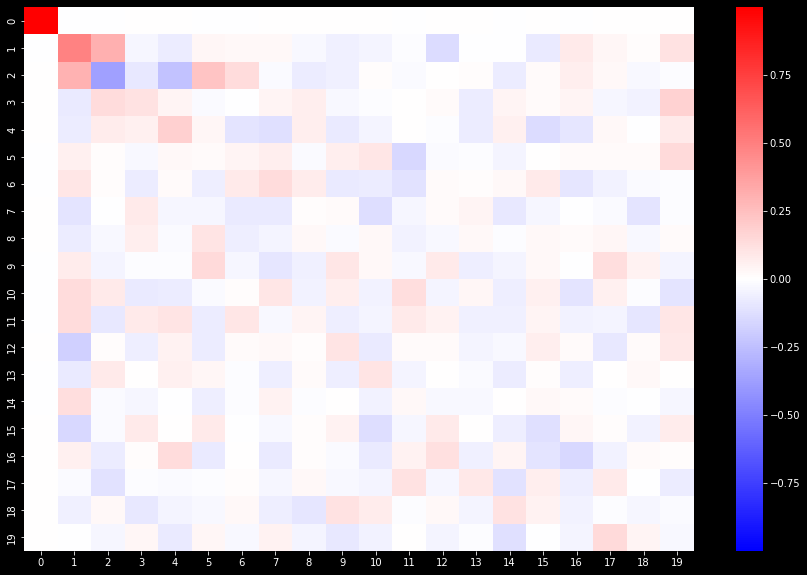

In [27]:
knn = 5
sigma = 2
appr = 'first'
max_task = 250


exp = exp_list[0]
task_id = '0'
task_idx = int(task_id)
task = exp['results'][task_id]

ev1 = calc_L_from_task(task, exp, max_task, knn, task_idx, sigma, appr)

exp = exp_list[0]
task_id = '1'
task_idx = int(task_id)
task = exp['results'][task_id]

ev2 = calc_L_from_task(task, exp, max_task, knn, task_idx, sigma, appr)
functional_map(ev1, ev2)

model: rec-vae continual
{'seed': 1737718091, 'wandb': True, 'dataset': 'rec-fmnist', 'model': 'rec-vae', 'optim': 'adam', 'lr': 0.001, 'scheduler_steps': 2, 'scheduler_gamma': 0.1, 'approach': 'continual', 'batch_size': 64, 'n_epochs': 30, 'latent_space': 32, 'kl_weight': 1.0, 'forward_sample': True, 'normalized_score': False, 'add_rotation': False, 'min_max_rotation': (-15, 15), 'poison_perc': 0, 'id': '63d31e32-45c3-4684-94fc-308dcfa074fb', 'timestamp': '2022-03-17 12:06:47.251205'}


Coputing:   0%|          | 0/12 [00:00<?, ?it/s]

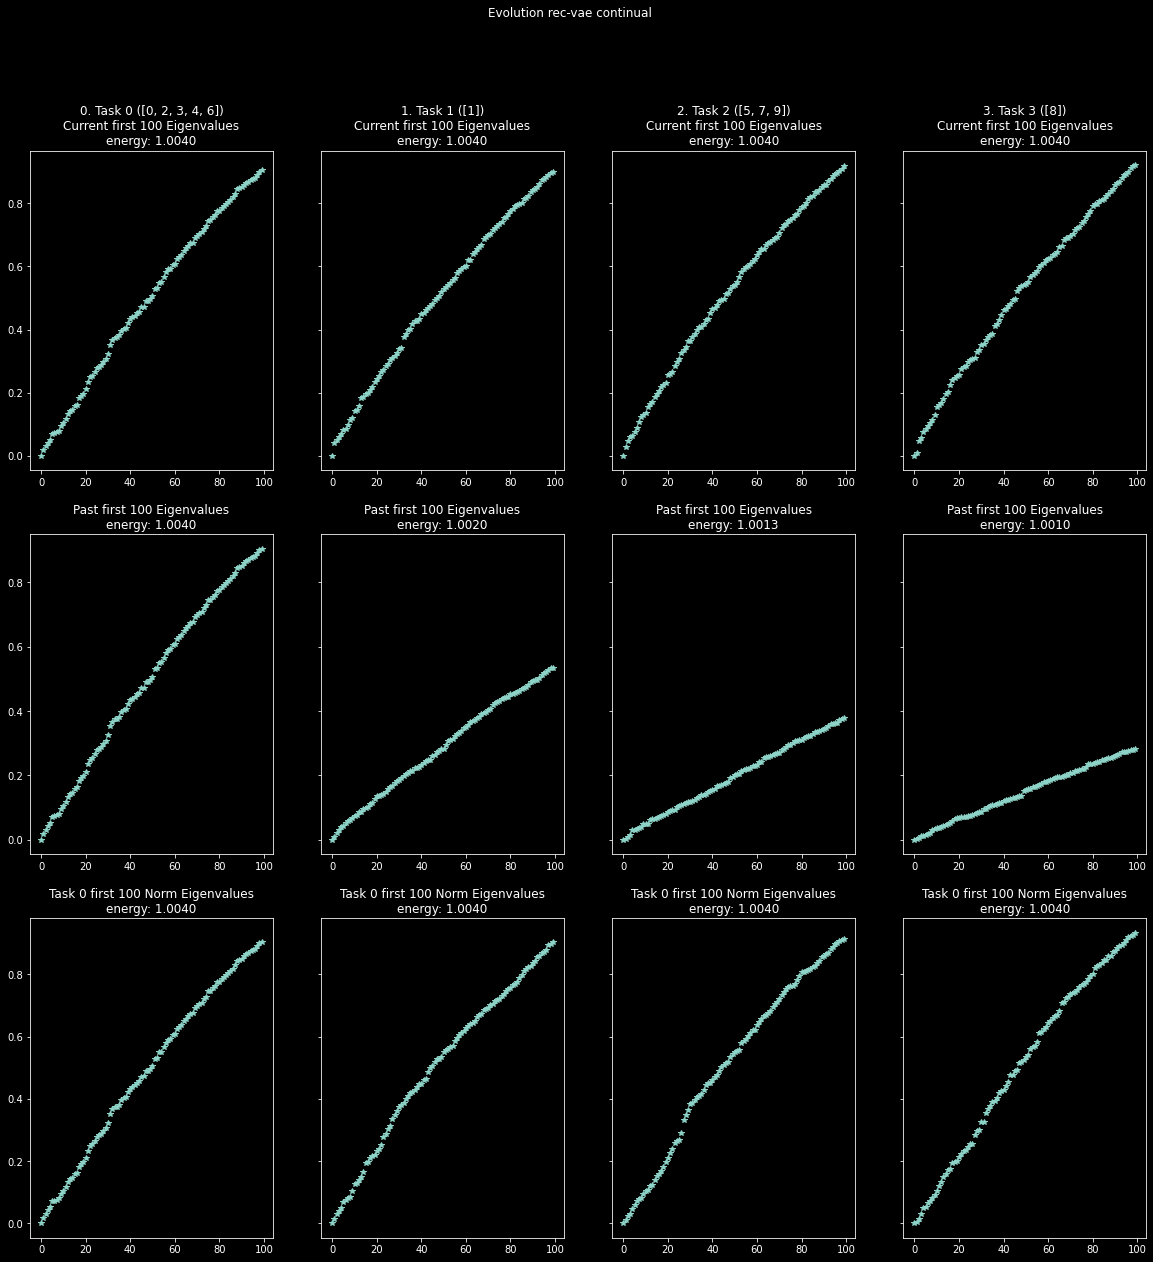

model: rec-vae joint
{'seed': 1565878936, 'wandb': True, 'dataset': 'rec-fmnist', 'model': 'rec-vae', 'optim': 'adam', 'lr': 0.001, 'scheduler_steps': 2, 'scheduler_gamma': 0.1, 'approach': 'joint', 'batch_size': 64, 'n_epochs': 30, 'latent_space': 32, 'kl_weight': 1.0, 'forward_sample': True, 'normalized_score': False, 'add_rotation': False, 'min_max_rotation': (-15, 15), 'poison_perc': 0, 'per_task': True, 'id': '82ccd192-1587-4d11-8782-d640f52f738a', 'timestamp': '2022-03-17 17:10:26.365602'}


Coputing:   0%|          | 0/12 [00:00<?, ?it/s]

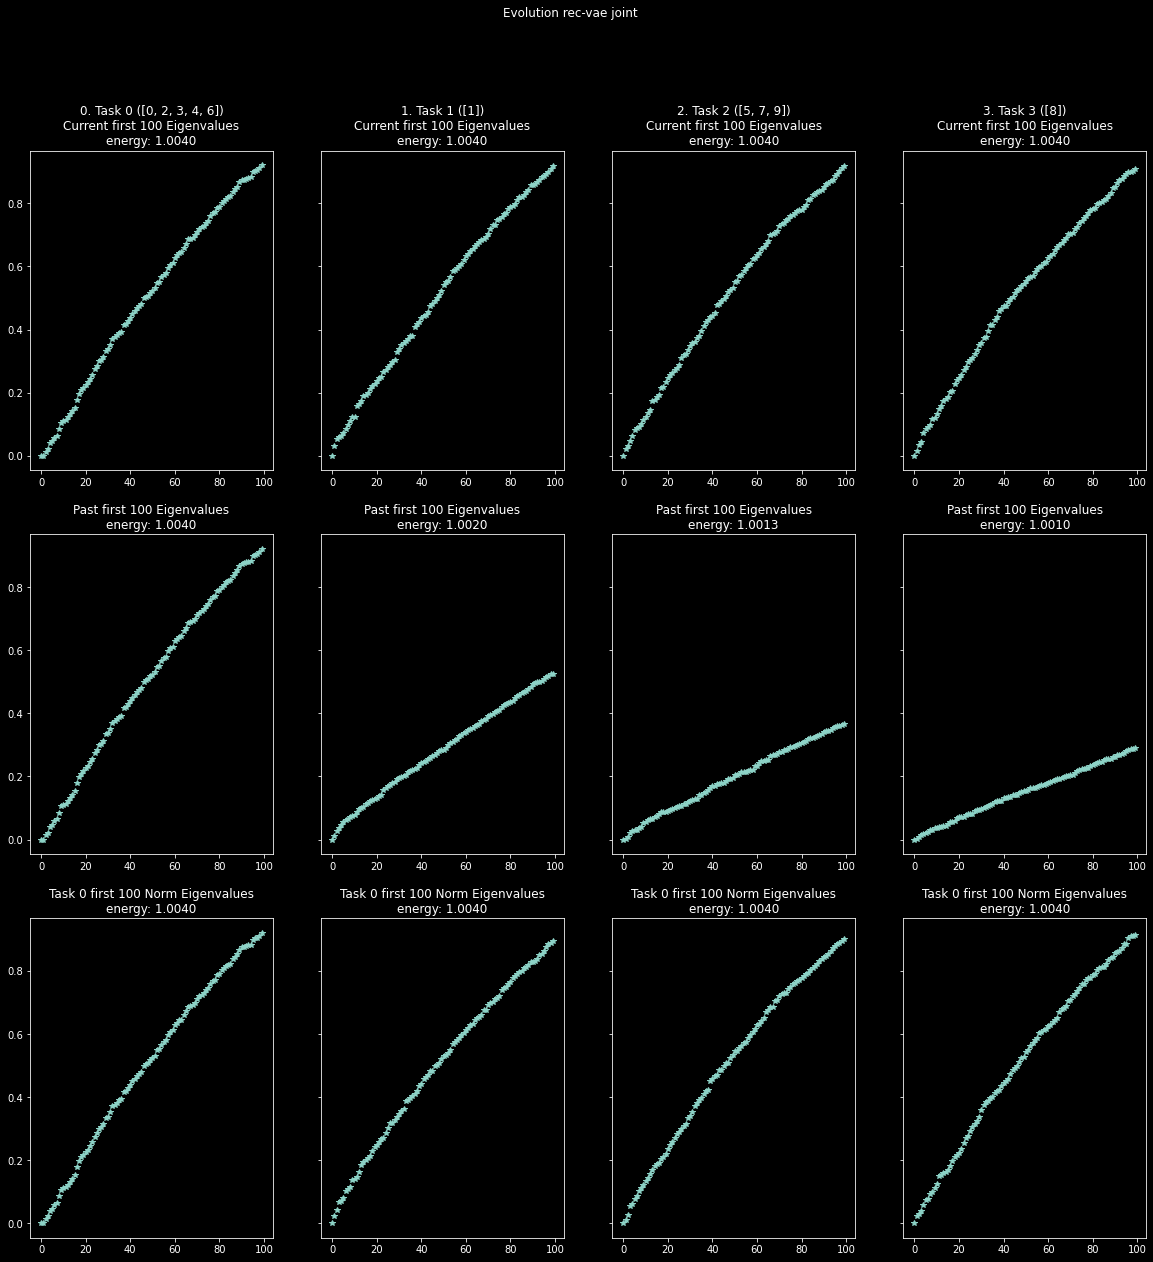

In [13]:
# exp = exp_list[4]
# figsize = (20, 10)
# limit = 100

def show_analysis(exp: dict, max_task=1000):
    print_exp_info(exp)
    nrows = 3
    ncols = len(exp['results'])
    figsize = (5*ncols, 5*nrows+5)
    limit = 100
    sigma = 5
    k = 3
    norma_lap = True
    norm_eigs = False

    fig, ax = plt.subplots(nrows, ncols, figsize=figsize, sharey='row')
    plt.suptitle(f'Evolution {exp["model"]} {exp["approach"]}')
    pbar = tqdm(desc=f'Coputing', total=nrows*ncols, leave=False)

    for task_id in exp['results']:
        task_idx = int(task_id)
        task = exp['results'][task_id]
        knowledge = get_knowledge_list(exp)
        rec_errs, latents, targets, logvars = task_reduction(task, knowledge, task_max=max_task)

        cur_nu = latents[np.isin(targets.cpu(), knowledge[task_idx])]
        past_nu = latents[np.isin(targets.cpu(), flatten_list(knowledge[:task_idx+1]))]
        first_nu = latents[np.isin(targets.cpu(), knowledge[0])]

        cur_logvars = logvars[np.isin(targets.cpu(), knowledge[task_idx])] if logvars is not None else None
        past_logvars = logvars[np.isin(targets.cpu(), flatten_list(knowledge[:task_idx+1]))] if logvars is not None else None
        first_logvars = logvars[np.isin(targets.cpu(), knowledge[0])] if logvars is not None else None

        targets_knowledge = targets.clone()
        for num, kn in enumerate(knowledge):
            targets_knowledge[torch.isin(targets, torch.Tensor(kn).to(device))] = num

        ax_idx = 0
        energy, eigenvalues, eigenvectors, L = laplacian_analysis(cur_nu, sigma=sigma, knn=k, logvars=cur_logvars,
                       norm_lap=norma_lap, norm_eigs=norm_eigs)
        ax[ax_idx][task_idx].plot(eigenvalues[:limit].cpu(), '*')
        ax[ax_idx][task_idx].set_title(f'{task_idx}. Task {task_id} ({knowledge[task_idx]})'
                        f'\nCurrent first {limit} Eigenvalues'
                        f'\nenergy: {energy:.4f}')
        ax_idx += 1
        pbar.update()
        energy, eigenvalues, eigenvectors, L = laplacian_analysis(past_nu, sigma=sigma, knn=k, logvars=past_logvars,
                       norm_lap=norma_lap, norm_eigs=norm_eigs)
        ax[ax_idx][task_idx].plot(eigenvalues[:limit].cpu(), '*')
        ax[ax_idx][task_idx].set_title(f'Past first {limit} Eigenvalues'
                                       f'\nenergy: {energy:.4f}')
        ax_idx += 1
        pbar.update()

        energy, eigenvalues, eigenvectors, L = laplacian_analysis(first_nu, sigma=sigma, knn=k, logvars=first_logvars, norm_lap=norma_lap, norm_eigs=norm_eigs)
        ax[ax_idx][task_idx].plot(eigenvalues[:limit].cpu(), '*')
        ax[ax_idx][task_idx].set_title(f'Task 0 first {limit} Norm Eigenvalues'
                                       f'\nenergy: {energy:.4f}')
        ax_idx += 1
        pbar.update()
    plt.show()


show_analysis(exp_list[0], max_task=250)
show_analysis(exp_list[2], max_task=250)

In [56]:
def exp_evolution(exp: dict, max_task=250):
    print('Experiment')
    print_exp_info(exp)
    nrows = 7
    ncols = len(exp['results'])
    figsize = (5*ncols, 5*nrows+5)
    limit = 100
    sigma = 3
    k = 5
    norma_lap = False
    norm_eigs = False

    fig, ax = plt.subplots(nrows, ncols, figsize=figsize, sharey='row')
    plt.suptitle(f'Evolution {exp["model"]} {exp["approach"]}')
    pbar = tqdm(desc=f'Coputing', total=nrows*ncols, leave=False)

    knowledge = get_knowledge_list(exp)

    for task_id in exp['results']:
        task_idx = int(task_id)
        task = exp['results'][task_id]
        rec_errs, latents, targets, logvars = task_reduction(task, knowledge, task_max=max_task)

        cur_latents = latents[np.isin(targets.cpu(), knowledge[task_idx])]
        past_latents = latents[np.isin(targets.cpu(), flatten_list(knowledge[:task_idx+1]))]

        first_latents = latents[np.isin(targets.cpu(), knowledge[0])]
        cur_logvars = logvars[np.isin(targets.cpu(), knowledge[task_idx])] if logvars is not None else None
        past_logvars = logvars[np.isin(targets.cpu(), flatten_list(knowledge[:task_idx+1]))] if logvars is not None else None
        first_logvars = logvars[np.isin(targets.cpu(), knowledge[0])] if logvars is not None else None

        targets_knowledge = targets.clone()
        for num, kn in enumerate(knowledge):
            targets_knowledge[torch.isin(targets, torch.Tensor(kn).to(device))] = num

        ax_idx = 0


        energy, eigenvalues, eigenvectors, L = laplacian_analysis(cur_latents, sigma=sigma, knn=k, logvars=cur_logvars,
                       norm_lap=norma_lap, norm_eigs=norm_eigs)
        ax[ax_idx][task_idx].plot(eigenvalues[:limit].cpu(), '*')
        ax[ax_idx][task_idx].set_title(f'{task_idx}. Task {task_id} ({knowledge[task_idx]})'
                        f'\nCurrent first {limit} Eigenvalues'
                        f'\nenergy: {energy:.4f}')
        ax_idx += 1
        pbar.update()

        energy, eigenvalues, eigenvectors, L = laplacian_analysis(past_latents, sigma=sigma, knn=k, logvars=past_logvars,
                               norm_lap=norma_lap, norm_eigs=norm_eigs)
        ax[ax_idx][task_idx].plot(eigenvalues[:limit].cpu(), '*')
        ax[ax_idx][task_idx].set_title(f'Past first {limit} Eigenvalues'
                                       f'\nenergy: {energy:.4f}')
        ax_idx += 1
        pbar.update()

        energy, eigenvalues, eigenvectors, L = laplacian_analysis(first_latents, sigma=sigma, knn=k, logvars=first_logvars,
                               norm_lap=norma_lap, norm_eigs=norm_eigs)
        ax[ax_idx][task_idx].plot(eigenvalues[:limit].cpu(), '*')
        ax[ax_idx][task_idx].set_title(f'Task 0 first {limit} Norm Eigenvalues'
                                       f'\nenergy: {energy:.4f}')
        ax_idx += 1
        pbar.update()

        energy, eigenvalues, eigenvectors, L = laplacian_analysis(latents, sigma=sigma, knn=k, logvars=logvars,
                               norm_lap=norma_lap, norm_eigs=norm_eigs)
        ev_limit = 11
        ts = TSNE(n_components=2, random_state=0, perplexity=30, init='random', learning_rate='auto')
        tr = ts.fit_transform(eigenvectors[:,:ev_limit].cpu().numpy())
        data = pd.DataFrame(np.concatenate([tr, targets_knowledge.cpu()[:, None]], axis=1), columns=['dim1','dim2','label'])
        sns.scatterplot(x='dim1', y='dim2', hue='label', data=data, palette='tab10', ax=ax[ax_idx][task_idx])
        ax[ax_idx][task_idx].set_title(f'TSNE first {ev_limit} eigenvectors')
        ax_idx += 1
        pbar.update()

        ev_limit = 5
        ts = TSNE(n_components=2, random_state=0, perplexity=30, init='random', learning_rate='auto')
        tr = ts.fit_transform(eigenvectors[:,:ev_limit].cpu().numpy())
        data = pd.DataFrame(np.concatenate([tr, targets_knowledge.cpu()[:, None]], axis=1), columns=['dim1','dim2','label'])
        sns.scatterplot(x='dim1', y='dim2', hue='label', data=data, palette='tab10', ax=ax[ax_idx][task_idx])
        ax[ax_idx][task_idx].set_title(f'TSNE first {ev_limit} eigenvectors')
        ax_idx += 1
        pbar.update()

        ts = TSNE(n_components=2, random_state=0, perplexity=30, init='random', learning_rate='auto')
        tr = ts.fit_transform(latents.cpu().numpy())
        data = pd.DataFrame(np.concatenate([tr, targets_knowledge.cpu()[:, None]], axis=1), columns=['dim1','dim2','label'])
        ax[ax_idx][task_idx].set_title(f'TSNE latent space')
        sns.scatterplot(x='dim1', y='dim2', hue='label', data=data, palette='tab10', ax=ax[ax_idx][task_idx])
        ax_idx += 1
        pbar.update()

        centroids = pd.DataFrame(np.concatenate([latents.cpu().numpy(), targets_knowledge.cpu().numpy()[:, None]],1),
                                 columns=[i for i in range(latents.shape[1])]+['label']).groupby('label').agg([np.mean, np.std])
        arr_centr = centroids.loc[:, (slice(None), 'mean')].values
        dist_matrix = ((arr_centr[None, ...] - np.expand_dims(arr_centr, 1)) ** 2).sum(-1)
        ax[ax_idx][task_idx].set_title(f'Centroids mutual distances')
        sns.heatmap(dist_matrix, annot=True, ax = ax[ax_idx][task_idx])
        ax_idx += 1
        pbar.update()

    pbar.clear()
    pbar.close()
    plt.show()

In [ ]:

G = nx.from_numpy_matrix(A, create_using=nx.MultiGraph)


Experiment
model: rec-vae continual
{'seed': 1737718091, 'wandb': True, 'dataset': 'rec-fmnist', 'model': 'rec-vae', 'optim': 'adam', 'lr': 0.001, 'scheduler_steps': 2, 'scheduler_gamma': 0.1, 'approach': 'continual', 'batch_size': 64, 'n_epochs': 30, 'latent_space': 32, 'kl_weight': 1.0, 'forward_sample': True, 'normalized_score': False, 'add_rotation': False, 'min_max_rotation': (-15, 15), 'poison_perc': 0, 'id': '63d31e32-45c3-4684-94fc-308dcfa074fb', 'timestamp': '2022-03-17 12:06:47.251205'}


Coputing:   0%|          | 0/28 [00:00<?, ?it/s]

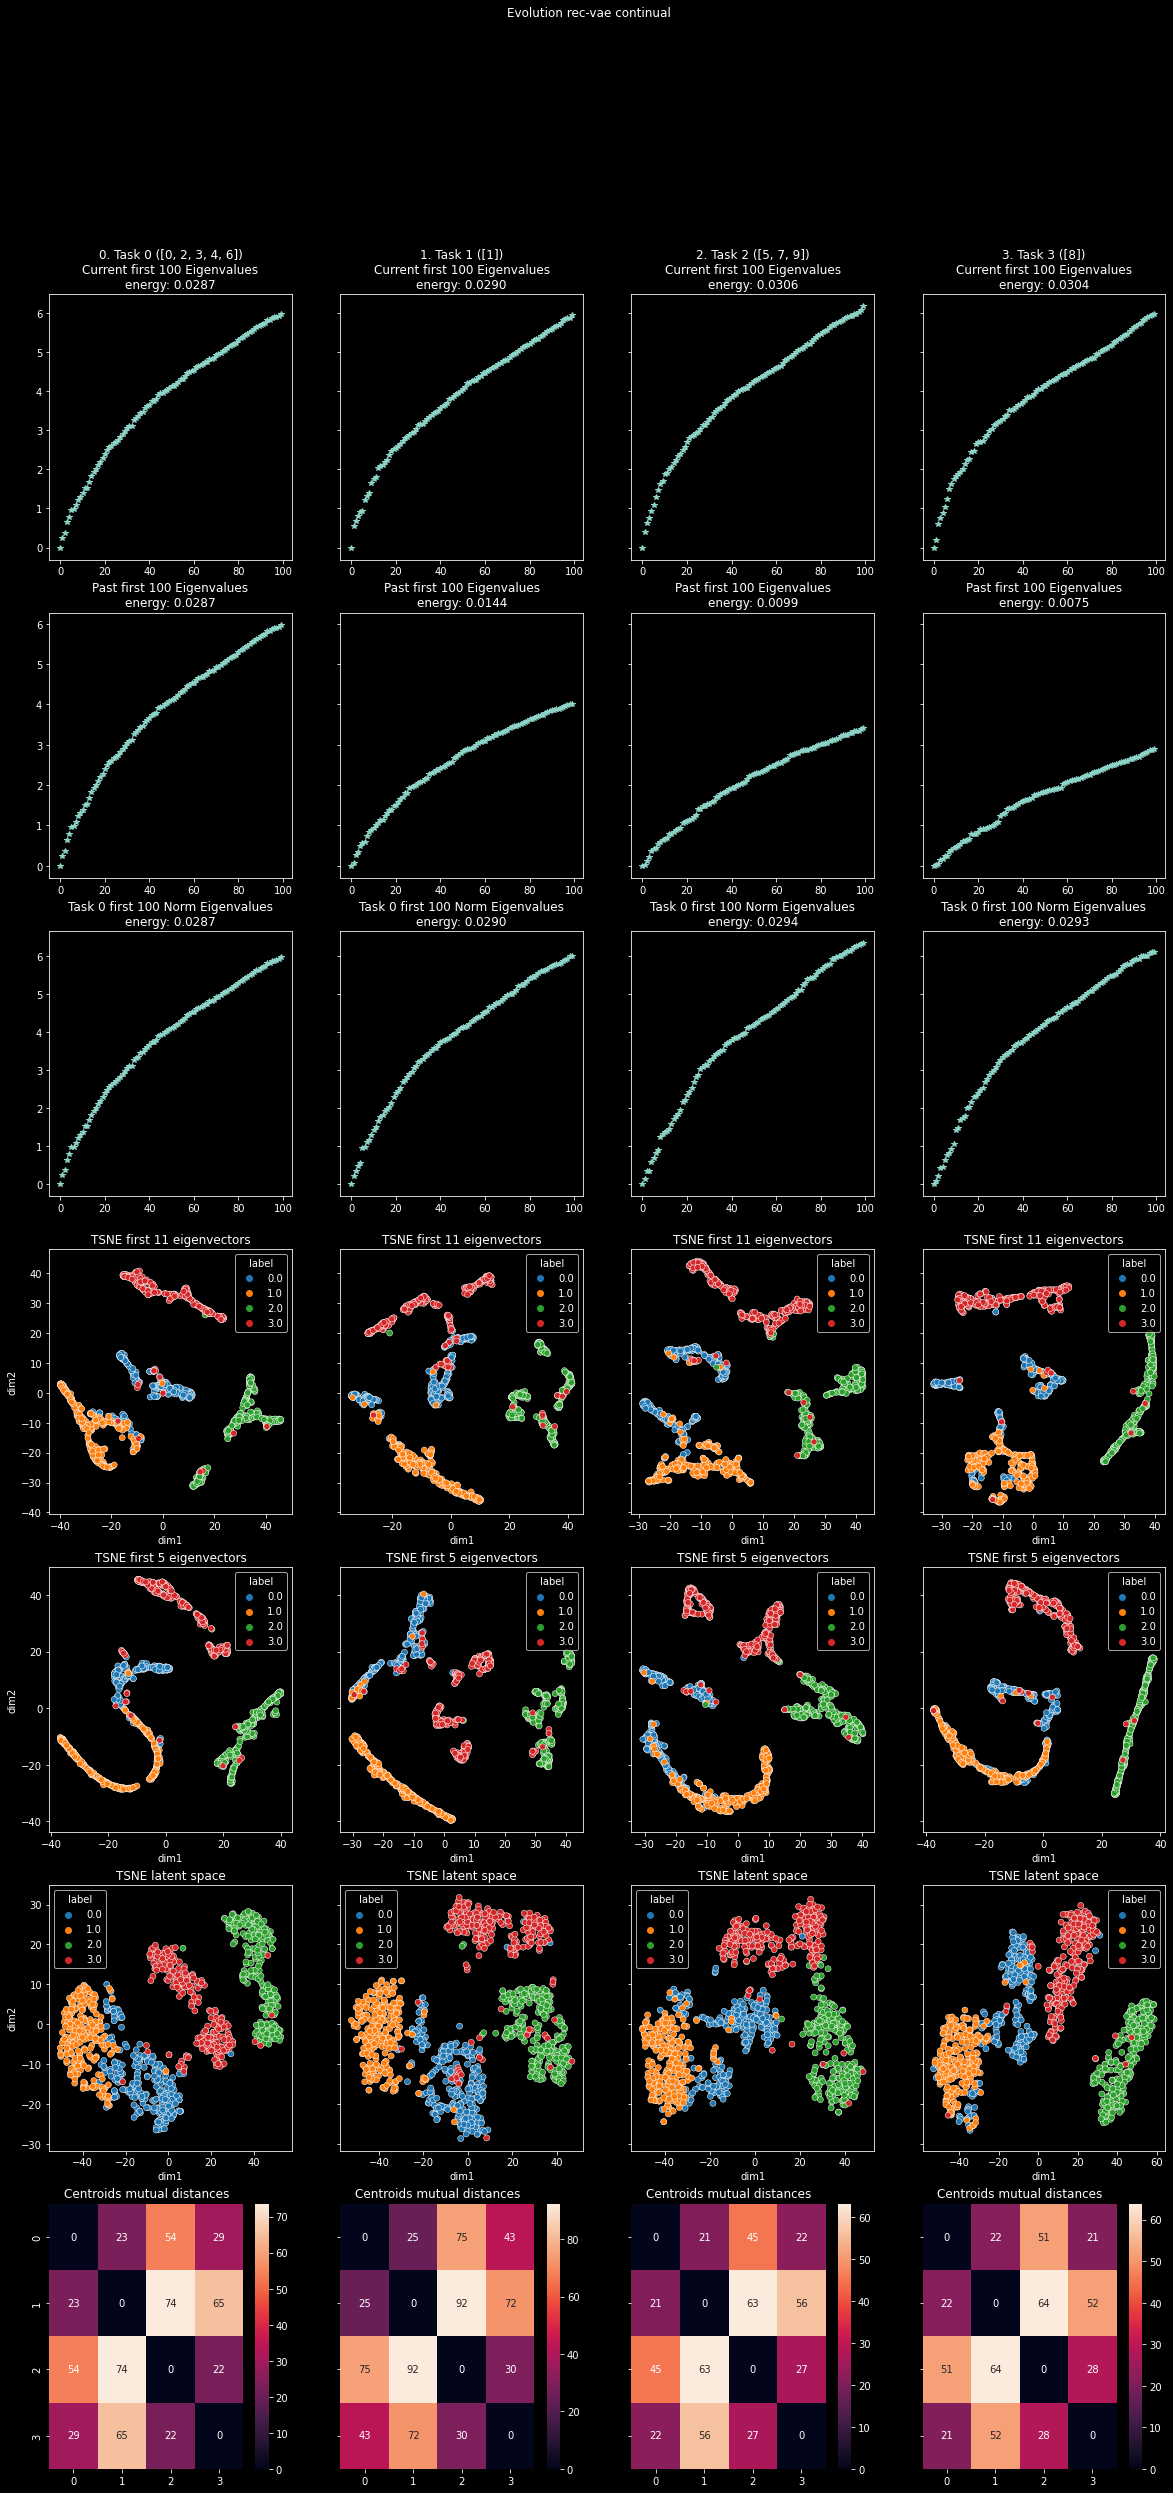

Experiment
model: rec-vae joint
{'seed': 1565878936, 'wandb': True, 'dataset': 'rec-fmnist', 'model': 'rec-vae', 'optim': 'adam', 'lr': 0.001, 'scheduler_steps': 2, 'scheduler_gamma': 0.1, 'approach': 'joint', 'batch_size': 64, 'n_epochs': 30, 'latent_space': 32, 'kl_weight': 1.0, 'forward_sample': True, 'normalized_score': False, 'add_rotation': False, 'min_max_rotation': (-15, 15), 'poison_perc': 0, 'per_task': True, 'id': '82ccd192-1587-4d11-8782-d640f52f738a', 'timestamp': '2022-03-17 17:10:26.365602'}


Coputing:   0%|          | 0/28 [00:00<?, ?it/s]

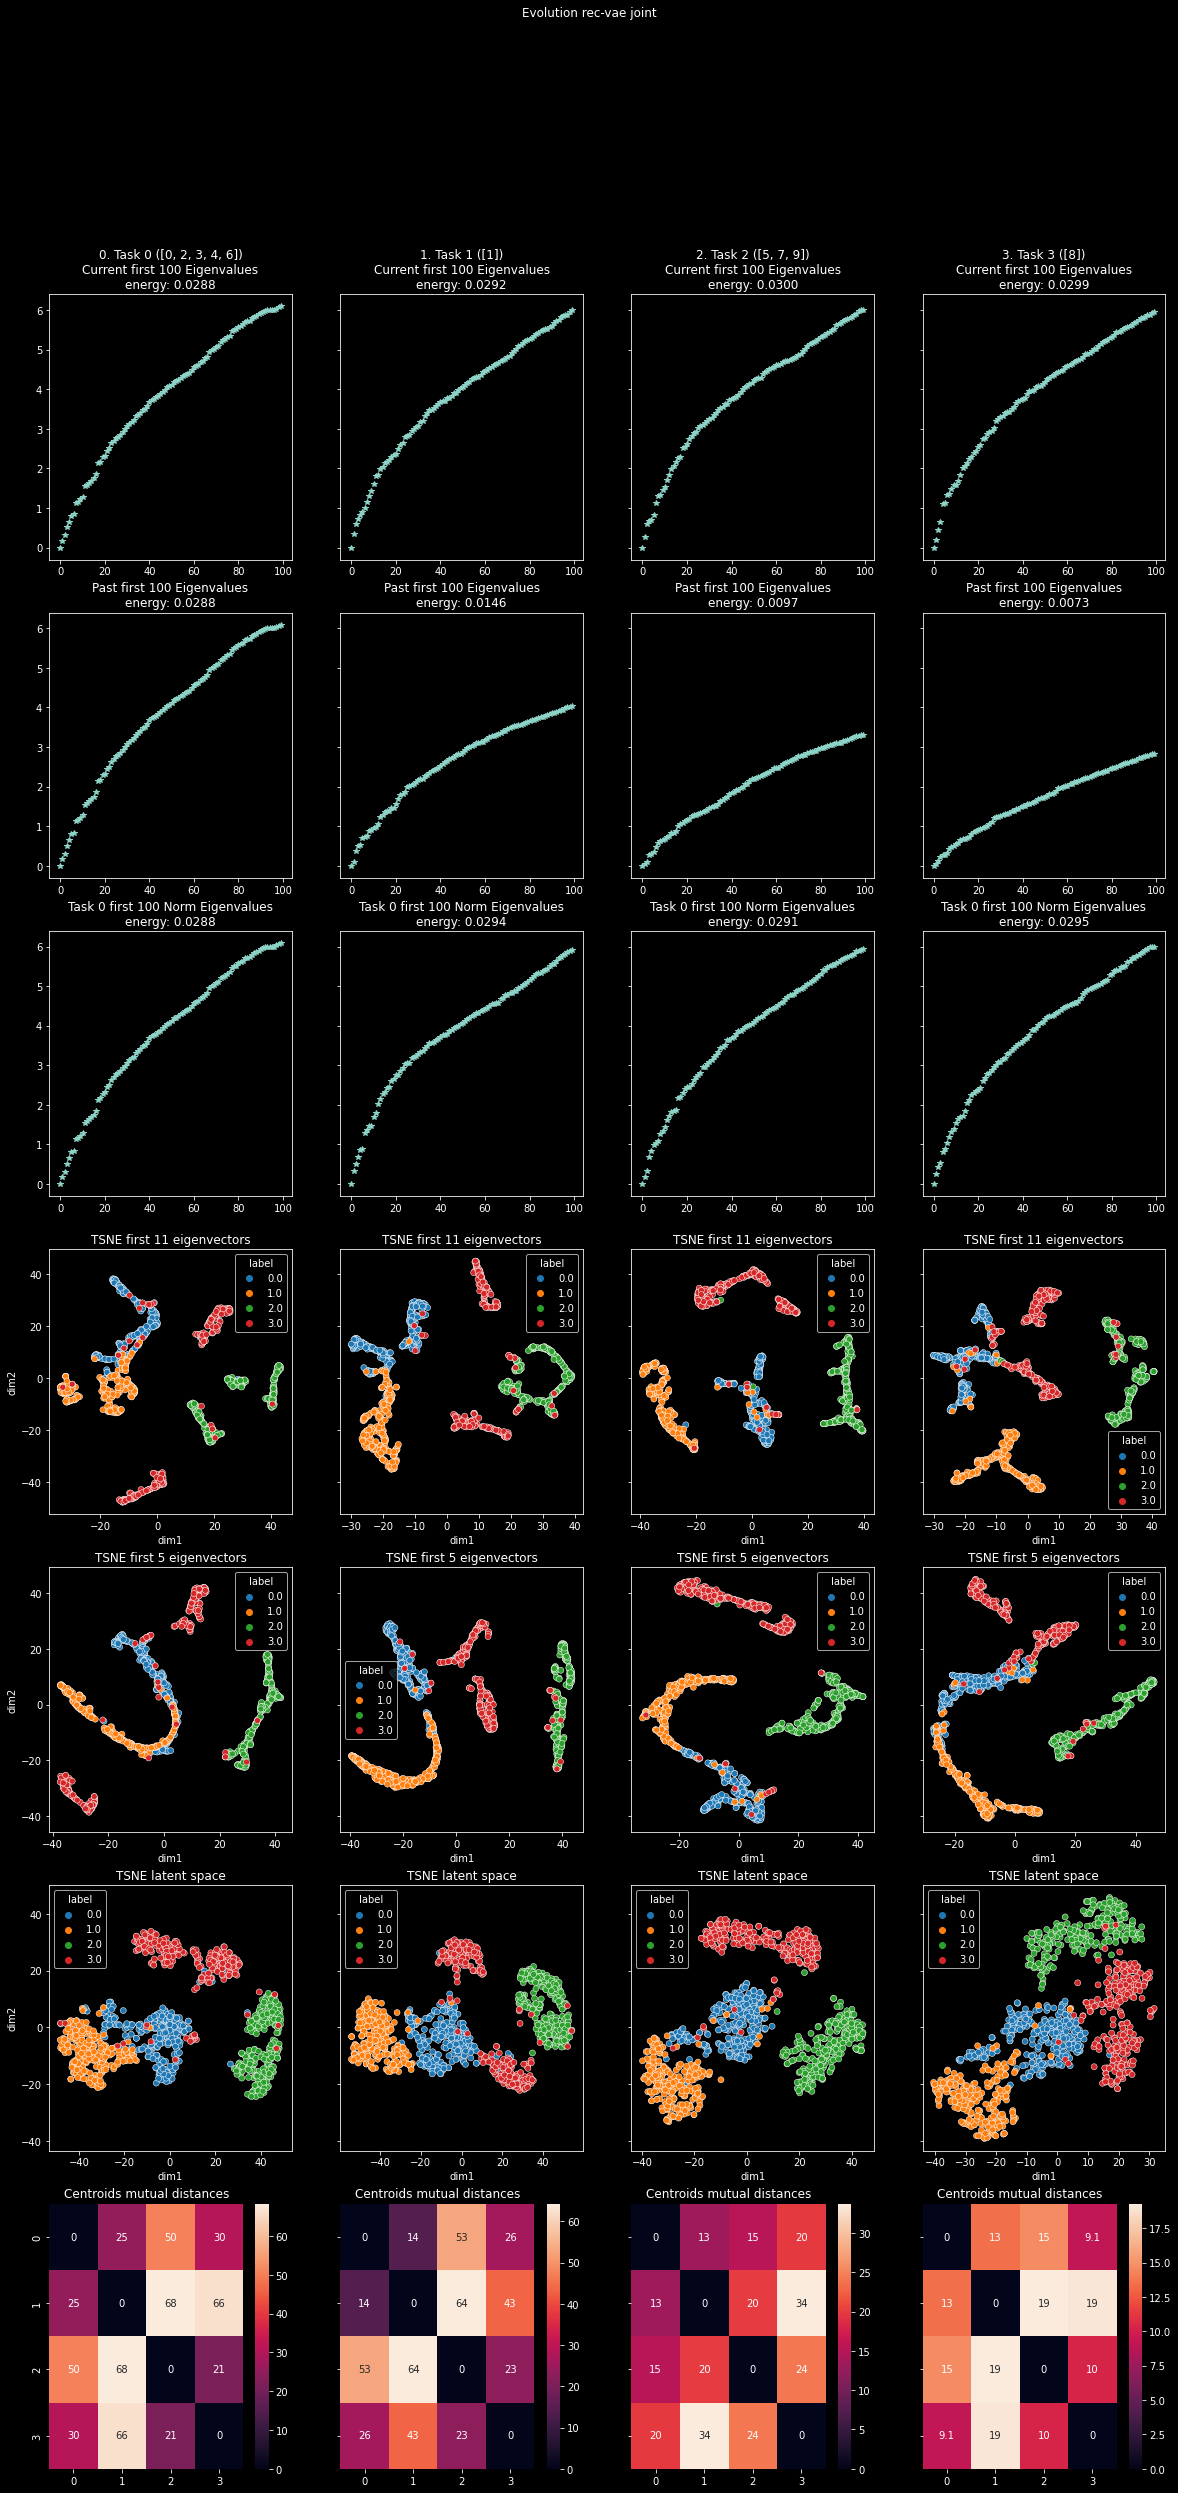

In [57]:
exp_evolution(exp_list[0])
exp_evolution(exp_list[2])

In [ ]:
# latents = torch.tensor(exp_list[2]['results']['0']['latents'], device=device)
# energy, neigenvalues, neigenvectors = dir_energy_normal(latents, sigma=3)
# A, D, L = calc_D_L_torch(latents, sigma=10)
# eigenvalues, eigenvectors = find_eig_torch(L)
# for i in range(10):
#     fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
#     plt.suptitle(f'Eigenvector {i}')
#     ax[0].plot(eigenvectors[:, i].cpu(), '*')
#     ax[0].set_title(f'Positives: {(eigenvectors[:, i] > 0).sum()}')
#     ax[0].set_ylim([-1.1, 1.1])
#     ax[1].plot(neigenvectors[:, i].cpu(), '*')
#     ax[1].set_title(f'Positives: {(neigenvectors[:, i] > 0).sum()}')
#     plt.show()

In [ ]:
def compare_exps(exps: list[dict], max_task=1000):
    print('Comparing experiments:')
    for exp in exps:
        print_exp_info(exp)
    nrows = 6
    figsize = (5*len(exps), 5*nrows+5)
    limit = 100

    knowledge = get_knowledge_list(exps[0])

    for task_id in exps[0]['results']:
        task_idx = int(task_id)

        fig, ax = plt.subplots(nrows, len(exps), figsize=figsize)
        plt.suptitle(f'{task_idx}. Task {task_id} ({knowledge[task_idx]})')
        pbar = tqdm(desc=f'Task {task_id}', total=nrows*len(exps), leave=False)

        for exp_idx, exp in enumerate(exps):
            task = exp['results'][task_id]
            rec_errs, latents, targets, logvars = task_reduction(task, knowledge, task_max=max_task)

            cur_latents = latents[np.isin(targets.cpu(), knowledge[task_idx])]
            past_latents = latents[np.isin(targets.cpu(), flatten_list(knowledge[:task_idx+1]))]

            targets_knowledge = targets.clone()
            for num, kn in enumerate(knowledge):
                targets_knowledge[torch.isin(targets, torch.Tensor(kn).to(device))] = num

            ax_idx = 0
            ax[ax_idx][exp_idx].set_title(f'{exp["model"]} {exp["approach"]}'
                            f'\nCurrent E={dir_energy(cur_latents, sigma)}'
                            f'\nPast E={dir_energy(past_latents, sigma)}\n'
                            f'\nCurrent first {limit} Eigenvalues')
            A, D, L = calc_D_L_torch(cur_latents, sigma=sigma)
            eigenvalues, eigenvectors = find_eig_torch(L)
            ax[ax_idx][exp_idx].plot(eigenvalues[1:limit].cpu(), '*')
            ax_idx += 1
            pbar.update()

            A, D, L = calc_D_L_torch(past_latents, sigma=sigma)
            eigenvalues, eigenvectors = find_eig_torch(L)
            ax[ax_idx][exp_idx].plot(eigenvalues[1:limit].cpu(), '*')
            ax[ax_idx][exp_idx].set_title(f'Past first {limit} Eigenvalues')
            ax_idx += 1
            pbar.update()

            A, D, L = calc_D_L_torch(latents, sigma=sigma)
            eigenvalues, eigenvectors = find_eig_torch(L)
            ev_limit = 11
            ts = TSNE(n_components=2, random_state=0, perplexity=30, init='random', learning_rate='auto')
            tr = ts.fit_transform(eigenvectors[:,:ev_limit].cpu().numpy())
            data = pd.DataFrame(np.concatenate([tr, targets_knowledge.cpu()[:, None]], axis=1), columns=['dim1','dim2','label'])
            sns.scatterplot(x='dim1', y='dim2', hue='label', data=data, palette='tab10', ax=ax[ax_idx][exp_idx])
            ax[ax_idx][exp_idx].set_title(f'TSNE first {ev_limit} eigenvectors')
            ax_idx += 1
            pbar.update()

            ev_limit = 5
            ts = TSNE(n_components=2, random_state=0, perplexity=30, init='random', learning_rate='auto')
            tr = ts.fit_transform(eigenvectors[:,:ev_limit].cpu().numpy())
            data = pd.DataFrame(np.concatenate([tr, targets_knowledge.cpu()[:, None]], axis=1), columns=['dim1','dim2','label'])
            sns.scatterplot(x='dim1', y='dim2', hue='label', data=data, palette='tab10', ax=ax[ax_idx][exp_idx])
            ax[ax_idx][exp_idx].set_title(f'TSNE first {ev_limit} eigenvectors')
            ax_idx += 1
            pbar.update()

            ts = TSNE(n_components=2, random_state=0, perplexity=30, init='random', learning_rate='auto')
            tr = ts.fit_transform(latents.cpu().numpy())
            data = pd.DataFrame(np.concatenate([tr, targets_knowledge.cpu()[:, None]], axis=1), columns=['dim1','dim2','label'])
            ax[ax_idx][exp_idx].set_title(f'TSNE latent space')
            sns.scatterplot(x='dim1', y='dim2', hue='label', data=data, palette='tab10', ax=ax[ax_idx][exp_idx])
            ax_idx += 1
            pbar.update()

            centroids = pd.DataFrame(np.concatenate([latents.cpu().numpy(), targets_knowledge.cpu().numpy()[:, None]],1),
                                     columns=[i for i in range(latents.shape[1])]+['label']).groupby('label').agg([np.mean, np.std])
            arr_centr = centroids.loc[:, (slice(None), 'mean')].values
            dist_matrix = ((arr_centr[None, ...] - np.expand_dims(arr_centr, 1)) ** 2).sum(-1)
            ax[ax_idx][exp_idx].set_title(f'Centroids mutual distances')
            sns.heatmap(dist_matrix, annot=True, ax = ax[ax_idx][exp_idx])
            ax_idx += 1
            pbar.update()
            # ax[ax_idx][exp_idx].set_title(f'Centroids standard deviation')
            # sns.heatmap(centroids.loc[:, (slice(None), 'std')].mean(1).to_frame(),annot=True,ax=ax[ax_idx][exp_idx])

        pbar.close()
        pbar.clear()
        plt.show()

In [ ]:
idx_to_cmp = []
if len(idx_to_cmp) > 0:
    compare_exps([exp_list[idx] for idx in idx_to_cmp], max_task=250)

In [ ]:
idx_to_show = [4, 5]
for idx in idx_to_show:
    print_exp_info(exp_list[idx])
    show_exp_images(exp_list[idx])